# Data Prep Space

This notebook file is here to make it easier to modify data extract files to suit the requirements of the pipeline. Should mainly be used for converting formats and changing column names.

In [112]:
from dotenv import load_dotenv
import psycopg2
import os
import sys
from collections import defaultdict
import pandas as pd
from tqdm import tqdm
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import re

char_regex = re.compile(r'[^a-z]')

In [113]:
load_dotenv()

#-----------------------------------------------------------------------------#
# DB connection

conn = psycopg2.connect(
    database="postgres", 
    user='postgres', 
    password=os.environ["POSTGRES_PASSWORD"], 
    host='127.0.0.1', 
    port= '5432'
)


In [114]:

def print_psycopg2_exception(err):
    # get details about the exception
    err_type, err_obj, traceback = sys.exc_info()

    # get the line number when exception occured
    line_num = traceback.tb_lineno

    # print the connect() error
    print("\npsycopg2 ERROR:", err, "on line number:", line_num)
    print("psycopg2 traceback:", traceback, "-- type:", err_type)

    # psycopg2 extensions.Diagnostics object attribute
    print("\nextensions.Diagnostics:", err.diag)

    # print the pgcode and pgerror exceptions
    print("pgerror:", err.pgerror)
    print("pgcode:", err.pgcode, "\n")

def transaction_wrapper(func):
    def wrapper(*args, **kwargs):
        with conn: 
            with conn.cursor() as cur:
                try:
                    cur.execute("savepoint my_save_point")
                    return func(cur, *args, **kwargs)
                except (psycopg2.DatabaseError) as error:
                    print_psycopg2_exception(error)
                    cur.execute("rollback to savepoint my_save_point")
                    raise
                except Exception as e:
                    cur.execute("rollback to savepoint my_save_point")
                    raise
    return wrapper

# Yes, this is redundant with the above. 
# Some repetition has been introduced into my queries 
# So tt's just easier to build them with f-strings. 
# We're not injecting user-supplied data so there's no security risk.
# If you hate it go refactor the uses of the above function to use this instead
@transaction_wrapper
def execute_query_and_return(cur, some_query):
    cur.execute(some_query)
    return cur.fetchall()

In [115]:
""" 
print("Extracting validation data for initial load...") 

with open("./queries/validation_join.sql") as f:
    all_data = execute_query_and_return(f.read())

all_people = defaultdict(lambda: [None for x in range(32)])

for person in tqdm(all_data):
    # QUT_IDENTITY_ID
    if pd.notna(person[1]):
        all_people[person[0]][1] = person[1]

        # SOURCE_SYSTEM
    if pd.notna(person[2]):
        all_people[person[0]][2] = person[2]
        
        # SOURCE_SYSTEM_ID
    if pd.notna(person[3]):
        all_people[person[0]][3] = person[3]

        # ACCESS_NAME
    if pd.notna(person[4]):
        all_people[person[0]][4] = person[4]

        # TITLE
    if pd.notna(person[5]):
        all_people[person[0]][5] = person[5]

        # GIVEN_NAME
    if pd.notna(person[6]):
        all_people[person[0]][6] = person[6]

        # OTHER_NAME3
    if pd.notna(person[7]):
        all_people[person[0]][7] = person[7]
        
        # FAMILY_NAME
    if pd.notna(person[8]):
        all_people[person[0]][8] = person[8]

        # FULL_NAME
    if pd.notna(person[9]):
        all_people[person[0]][9] = person[9]

        # PREFERRED_GIVEN_NAME
    if pd.notna(person[10]):
        all_people[person[0]][10] = person[10]

        # DOB
    if pd.notna(person[11]):
        all_people[person[0]][11] = person[11]
        
        # GENDER
    if pd.notna(person[12]):
        all_people[person[0]][12] = person[12]

        # PER_EMAIL_ADDR
    if pd.notna(person[13]):
        all_people[person[0]][13] = person[13]
        
        # STU_EMAIL_ADDR
    if pd.notna(person[14]):
        all_people[person[0]][14] = person[14]

        # WORK_EMAIL_ADDR
    if pd.notna(person[15]):
        all_people[person[0]][15] = person[15]

        # PHONE_PERS
    if pd.notna(person[16]):
        all_people[person[0]][16] = person[16]
        
        # PHONE_WORK
    if pd.notna(person[17]):
        all_people[person[0]][17] = person[17]

        # PHONE_MOBILE
    if pd.notna(person[18]):
        all_people[person[0]][18] = person[18]

        # WORK_MOBILE
    if pd.notna(person[19]):
        all_people[person[0]][19] = person[19]

    # 20-25 are:
    # ADDR1_HOME
    # ADDR2_HOME
    # ADDR3_HOME
    # STATE_HOME
    # COUNTRY_HOME
    # POSTCODE_HOME
    if any(pd.notna(x) for x in person[20:26]):
        all_people[person[0]][20:26] = person[20:26]
    
    # 26-31 are:
    # ADDR1_POST
    # ADDR2_POST
    # ADDR3_POST
    # STATE_POST
    # COUNTRY_POST
    # POSTCODE_POST
    if any(pd.notna(x) for x in person[26:32]):
        all_people[person[0]][26:32] = person[26:32]

output = pd.DataFrame.from_dict(
    all_people, 
    orient='index',
    dtype=str, 
    columns=[
        "to_drop",
        "QUT_IDENTITY_ID", 
        "SOURCE_SYSTEM", 
        "SOURCE_SYSTEM_ID", 
        "ACCESS_NAME",
        "TITLE",
        "GIVEN_NAME", 
        "OTHER_NAME",
        "FAMILY_NAME",
        "FULL_NAME",
        "PREFERRED_GIVEN_NAME",
        "DOB", 
        "GENDER",
        "PER_EMAIL_ADDR", 
        "STU_EMAIL_ADDR",
        "WORK_EMAIL_ADDR",
        "PHONE_PERS",
        "PHONE_WORK",
        "PHONE_MOBILE",
        "WORK_MOBILE",
        "ADDR1_HOME",
        "ADDR2_HOME",
        "ADDR3_HOME",
        "STATE_HOME",
        "COUNTRY_HOME",
        "POSTCODE_HOME",
        "ADDR1_POST",
        "ADDR2_POST",
        "ADDR3_POST",
        "STATE_POST",
        "COUNTRY_POST",
        "POSTCODE_POST"
    ])

output.drop(columns=["to_drop"], inplace=True)

output.to_csv("./raw_data/validation_join.csv", index=False) """

' \nprint("Extracting validation data for initial load...") \n\nwith open("./queries/validation_join.sql") as f:\n    all_data = execute_query_and_return(f.read())\n\nall_people = defaultdict(lambda: [None for x in range(32)])\n\nfor person in tqdm(all_data):\n    # QUT_IDENTITY_ID\n    if pd.notna(person[1]):\n        all_people[person[0]][1] = person[1]\n\n        # SOURCE_SYSTEM\n    if pd.notna(person[2]):\n        all_people[person[0]][2] = person[2]\n        \n        # SOURCE_SYSTEM_ID\n    if pd.notna(person[3]):\n        all_people[person[0]][3] = person[3]\n\n        # ACCESS_NAME\n    if pd.notna(person[4]):\n        all_people[person[0]][4] = person[4]\n\n        # TITLE\n    if pd.notna(person[5]):\n        all_people[person[0]][5] = person[5]\n\n        # GIVEN_NAME\n    if pd.notna(person[6]):\n        all_people[person[0]][6] = person[6]\n\n        # OTHER_NAME3\n    if pd.notna(person[7]):\n        all_people[person[0]][7] = person[7]\n        \n        # FAMILY_NAME\n

In [116]:
# output[output["QUT_IDENTITY_ID"]=="641dc0d5-e89b-43c6-bf55-8757fc894487"].PHONE_MOBILE

In [117]:
dobs = [dob[0] for dob in execute_query_and_return("SELECT DOB FROM RAW_DATA;")]

In [118]:
given_names = (name[0] for name in execute_query_and_return("SELECT given_name FROM RAW_DATA;") if name[0] is not None)

In [119]:
family_names = (name[0] for name in execute_query_and_return("SELECT family_name FROM RAW_DATA;") if name[0] is not None)

In [120]:
full_names = ((name[0], name[1]) for name in execute_query_and_return("SELECT given_name, family_name FROM RAW_DATA;") if name[0] is not None and name[1] is not None)

In [121]:
full_names_and_dobs = [
    (person[0], person[1], person[2]) 
    for person in execute_query_and_return(
        "SELECT given_name, family_name, dob FROM RAW_DATA;"
    ) if person[0] is not None 
        and person[1] is not None 
        and person[2] is not None
]

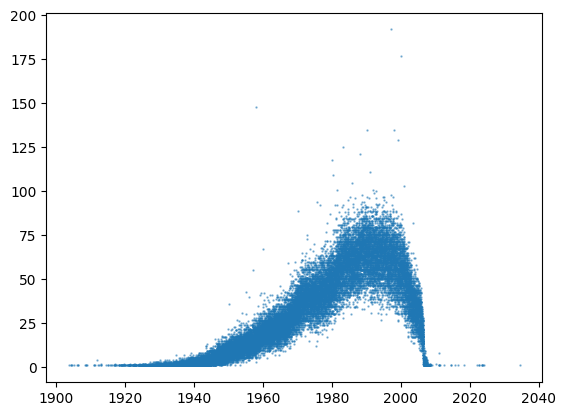

In [123]:
cutoffdate = datetime(year=1903, month=1, day=1).date()

dob_counts = defaultdict(lambda: 0)

for dob in dobs:
    if dob is not None and dob>cutoffdate:
        dob_counts[dob]+=1

dob_counts = sorted(list(dob_counts.items()), key=lambda item: item[0])

plt.scatter(
    [x[0] for x in dob_counts], 
    [y[1] for y in dob_counts], 
    alpha=0.5,
    s=0.5
    )

## Top 1000 Given Names By Count

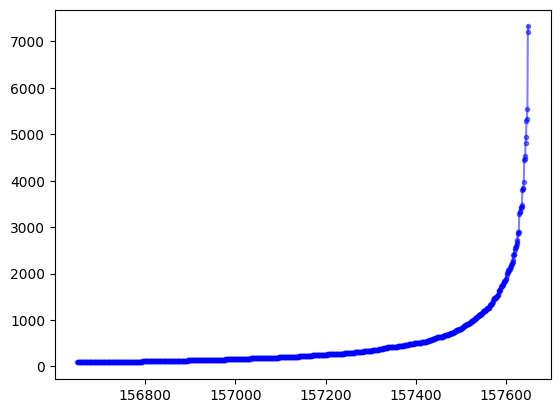

In [124]:
import re
display(Markdown("## Top 1000 Given Names By Count"))
given_counts = defaultdict(lambda: 0)

for name in given_names:
    if bool(re.sub(char_regex, '', name.lower())):
        given_counts[re.sub(char_regex, '', name.lower())]+=1

given_counts = [(index, item[1]) for index, item in enumerate(sorted(list(given_counts.items()), key=lambda item: item[1]))][-1000:]

plt.plot(
    [x[0] for x in given_counts], 
    [y[1] for y in given_counts], 
    'bo-',
    alpha=0.5,
    markersize=3
)





## Top 1000 Family Names By Count

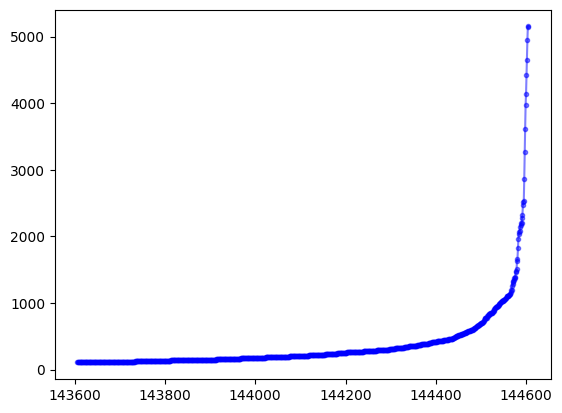

In [125]:
display(Markdown("## Top 1000 Family Names By Count"))
family_counts = defaultdict(lambda: 0)

for name in family_names:
    if bool(re.sub(char_regex, '', name.lower())):
        family_counts[re.sub(char_regex, '', name.lower())]+=1

family_counts = [(index, item[1]) for index, item in enumerate(sorted(list(family_counts.items()), key=lambda item: item[1]))][-1000:]

plt.plot(
    [x[0] for x in family_counts], 
    [y[1] for y in family_counts], 
    'bo-',
    alpha=0.5,
    markersize=3
)

## Top 1000 Full Names Counted By Discrete Birthdays Between 1980 and 2000

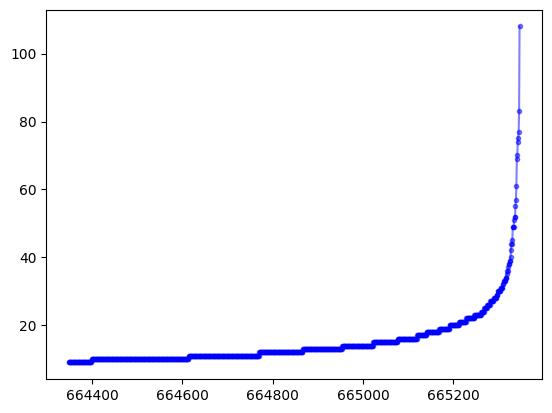

In [126]:
birthday_dict = defaultdict(lambda: set())

for person in full_names_and_dobs:
    birthday_dict[f"{re.sub(char_regex, '', person[0].lower())}{re.sub(char_regex, '', person[1].lower())}"].add(person[2])

person_count_dict = {name: len(birthday_set) for name, birthday_set in birthday_dict.items()}

person_counts_list = [(index, value) for index, value in enumerate(sorted(list(person_count_dict.values())))][-1000:]

display(Markdown("## Top 1000 Full Names Counted By Discrete Birthdays Between 1980 and 2000"))

plt.plot(
    [x[0] for x in person_counts_list], 
    [y[1] for y in person_counts_list], 
    'bo-',
    alpha=0.5,
    markersize=3
)






In [127]:
display(Markdown("## Naive Collision Probabilities"))
def collision_probability(num_peeps):
    chance_ok = 1
    for x in range(num_peeps):
        chance_ok = chance_ok * ((32850-x)/32850)
    return (1-chance_ok)*100

total = sum(person_count_dict.values())

top_ten = {name: count for name, count in person_count_dict.items() if count>=person_counts_list[-10][1]}

for name, count in top_ten.items():
    print(f"{name} appears ~{count} times overall -> {collision_probability(count)}% chance of collision")

## Naive Collision Probabilities

harpreetsingh appears ~77 times overall -> 8.528319120629025% chance of collision
gurpreetsingh appears ~74 times overall -> 7.898928934963479% chance of collision
amandeepkaur appears ~83 times overall -> 9.848528638786735% chance of collision
ramandeepkaur appears ~61 times overall -> 5.421687707609124% chance of collision
mandeepkaur appears ~57 times overall -> 4.744968856816234% chance of collision
jaspreetkaur appears ~55 times overall -> 4.422284989352776% chance of collision
harpreetkaur appears ~75 times overall -> 8.106401667347429% chance of collision
manpreetsingh appears ~69 times overall -> 6.89713383813928% chance of collision
sandeepkaur appears ~70 times overall -> 7.092692369803466% chance of collision
manpreetkaur appears ~108 times overall -> 16.14512750322773% chance of collision


In [ ]:
early_cutoffdate = datetime(year=1980, month=1, day=1).date()
late_cutoffdate = datetime(year=2000, month=12, day=31).date()

dob_counts = defaultdict(lambda: 0)

for dob in dobs:
    if dob is not None and dob>cutoffdate:
        dob_counts[dob]+=1

dob_counts = sorted(list(dob_counts.items()), key=lambda item: item[0])

plt.scatter(
    [x[0] for x in dob_counts], 
    [y[1] for y in dob_counts], 
    alpha=0.5,
    s=0.5
    )

In [129]:
birthday_dict = defaultdict(lambda: set())

for person in full_names_and_dobs:
    if datetime(year=1980, month=1, day=1).date() < person[2] < datetime(year=2000, month=12, day=31).date():
        birthday_dict[f"{re.sub(char_regex, '', person[0].lower())}{re.sub(char_regex, '', person[1].lower())}"].add(person[2])

person_count_dict = {name: len(birthday_set) for name, birthday_set in birthday_dict.items()}

person_counts_list = [(index, value) for index, value in enumerate(sorted(list(person_count_dict.values())))][-1000:]

display(Markdown("## Realistic Collision Probabilities"))
def collision_probability(num_peeps):
    chance_ok = 1
    for x in range(num_peeps):
        chance_ok = chance_ok * ((7300-x)/7300)
    return (1-chance_ok)*100

total = sum(person_count_dict.values())

top_ten = {name: count for name, count in person_count_dict.items() if count>=person_counts_list[-10][1]}

for name, count in top_ten.items():
    print(f"{name} appears ~{count} times in the ~7300 days between 1980 and 2000-> {collision_probability(count)}% chance of collision")


## Realistic Collision Probabilities

gurpreetsingh appears ~64 times in the ~7300 days between 1980 and 2000-> 24.192172610138797% chance of collision
amandeepkaur appears ~79 times in the ~7300 days between 1980 and 2000-> 34.52984696069768% chance of collision
ramandeepkaur appears ~55 times in the ~7300 days between 1980 and 2000-> 18.448282386718382% chance of collision
mandeepkaur appears ~54 times in the ~7300 days between 1980 and 2000-> 17.840527383804062% chance of collision
harpreetsingh appears ~64 times in the ~7300 days between 1980 and 2000-> 24.192172610138797% chance of collision
harpreetkaur appears ~65 times in the ~7300 days between 1980 and 2000-> 24.85678917903621% chance of collision
manpreetsingh appears ~64 times in the ~7300 days between 1980 and 2000-> 24.192172610138797% chance of collision
jaspreetkaur appears ~50 times in the ~7300 days between 1980 and 2000-> 15.480575542801866% chance of collision
sandeepkaur appears ~68 times in the ~7300 days between 1980 and 2000-> 26.876550096122862% cha